## Importing Libraries

In [20]:
import numpy as np
from scipy.linalg import expm
from scipy.sparse import lil_matrix
import matplotlib.pyplot as plt
import scipy

## Generate s-sparse (Random or Synthetic) Hermitian Matrix

In [21]:
def generate_s_sparse_hermitian(M, s, real_vals=False, seed=None, choice='random'):
    
    """
    Generate an s-sparse Hermitian matrix of size n x n.
    
    Parameters:
        M (int): Size of the matrix (M x M).
        s (int): Maximum number of non-zero elements per row/column.
        real_vals (bool): If True, generate real symmetric matrix instead.
        seed (int or None): Random seed for reproducibility.
        
    Returns:
        A (scipy.sparse.csr_matrix): s-sparse Hermitian matrix.
    """

    if M <= 0 or s < 0:
        raise ValueError("Matrix size n must be positive and sparsity s must be non-negative.")
    if s > M:
        raise ValueError("Sparsity s cannot be greater than matrix size n.")
    
    # Set random seed for reproducibility
    if seed is not None:
        np.random.seed(seed)

    if choice=='random':

        A = lil_matrix((M, M), dtype=np.complex128)

        for i in range(M):
            # Choose s unique indices for non-zero elements in row i
            col_indices = np.random.choice(M, min(s, M))
            for j in col_indices:
                if i <= j:
                    # Generate a random complex (or real) number
                    if real_vals:
                        val = np.random.randn()
                    else:
                        val = np.random.randn() + 1j * np.random.randn()
                    A[i, j] = val
                    A[j, i] = np.conj(val)  # Hermitian symmetry

        A = A.toarray()

        A = A/np.max(np.abs(np.linalg.eigvalsh(A))) # Quantum Block-Encoding

        max_norm = np.max(np.abs(A))
        if max_norm > 1:
            A = A /(s * max_norm)  # Normalize to ensure spectral radius <= 1
        else:
            A = A / s

        return A

    elif choice=='synthetic':
        """Generates a synthetic Hermitian matrix."""
        i, j = np.meshgrid(np.arange(M), np.arange(M), indexing="ij")
        A = np.exp(-0.5 * np.abs(i - j)) * np.sin(i + j)
        # H[np.abs(H) < 1e-5] = 0  # Set small values to zero

        A = A/np.max(np.abs(np.linalg.eigvalsh(A)))
        max_norm = np.max(np.abs(A))

        if max_norm > 1:
            A /= (M * max_norm)
        else:
            A /= M

        return A

    else:
        raise ValueError("Invalid choice. Use 'random' or 'synthetic'.")

### Diagonalization

In [22]:
def diagonalization(H, Psi_F, N=None, epsilon=1e-12):
    """
    Diagonalizes the projected Hamiltonian using thresholded overlap matrix.
    
    Parameters:
        H      : ndarray (n, n), the Hermitian matrix (Hamiltonian)
        Psi_F  : ndarray (n, k), Krylov-like basis vectors
        epsilon: float, eigenvalue threshold for the overlap matrix S

    Returns:
        eigenvals: array of eigenvalues
        eigenvecs: array of eigenvectors (in reduced subspace)
    """

    # Projected Hamiltonian and Overlap
    H_proj = Psi_F.conj().T @ H @ Psi_F
    S_proj = Psi_F.conj().T @ Psi_F

    try:
        eigenvals, eigenvecs = scipy.linalg.eigh(H_proj, S_proj)
    except np.linalg.LinAlgError:
        # Eigendecomposition of S
        print("Matrix is not positive definite. Regularizing")    
        eigvals_S, eigvecs_S = np.linalg.eigh(S_proj)
        # Thresholding
        idx = eigvals_S > epsilon

        # if the number of indices are less than N, raise error
        if np.sum(idx) < N:
            raise ValueError("Not enough eigenvalues above threshold!")
        
        V_thresh = eigvecs_S[:, idx]              # Orthonormal basis vectors
        D_thresh = np.diag(eigvals_S[idx])        # > epsilon

        # Transform to thresholded subspace
        H_thresh = V_thresh.conj().T @ H_proj @ V_thresh
        S_thresh = V_thresh.conj().T @ S_proj @ V_thresh
        # Note: S_thresh = V_thresh^† S V_thresh = D_thresh (positive definite)
        # Solve standard EVP since S_thresh is ~identity after truncation
        eigenvals, eigenvecs = scipy.linalg.eigh(H_thresh, S_thresh)

        # Optional: lift eigenvectors back to full Psi_F space if needed
        eigenvecs = V_thresh @ eigenvecs


    return eigenvals, eigenvecs

### Orthogonalization

In [23]:
def orthogonalization(Psi_F, eigenvecs):
    Psi_0 = Psi_F @ eigenvecs

    # Normalize the filtered state
    # Psi_0 /= np.linalg.norm(Psi_0, axis=0, keepdims=True)
    return Psi_0

## Quantum Krylov Methods (QSMs)
### QITE

In [24]:
def QITE(H, psi_0, N, tau = 1, buffer=50, epsilon = 1e-12, max_iter = 100):

    M = H.shape[0]
    H = (H + np.eye(M))/2
    Ntilde = int(np.ceil((1+(buffer/100)) * N))
    itr = 0
    abs_error = [1e16]

    print()
    print("QITE Krylov basis Diagonalization Parameters")
    print(f"Dimension of H matrix: {M}")
    print(f"Initial Space Size: {Ntilde}")
    print(f"Number of desired Eigenvalues: {N}")
    print(f"Tau: {tau}")
    print(f"Buffer: {buffer}%")
    print(f"Convergence Threshold: {epsilon}")
    print(f"Max Iterations: {max_iter}")
    print()

    last_valid_eigenvals = None
    exp_H = expm(- tau * H)
    eigh = np.linalg.eigvalsh(H)
    
    while itr < max_iter and abs_error[-1] >= epsilon and Ntilde <= M:
        
        # Initialization
        print(f"Iteration {itr}")
        if itr == 0:
            Psi_0 = np.empty((M, Ntilde), dtype=complex)
            v = psi_0.copy()
            for i in range(Ntilde):
                Psi_0[:, i] = v.flatten()
                v = exp_H @ v
        else:
            # Reuse previous Psi_0 and append just one column
            Psi_0 = np.column_stack((Psi_0, exp_H @ Psi_0[:, -1]))

        
        # Diagonalization
        try:
            eigenvals, _ = diagonalization(H, Psi_0, N)
        except np.linalg.LinAlgError as e:
            print(f"QITE Diagonalization Error at iteration {itr}: {str(e)}")
            print("Returning last successfully computed eigenvalues/eigenvectors.")
            return last_valid_eigenvals, abs_error, itr
        
        # Compute Errors
        idx = np.argsort(eigenvals)
        eigenvals = eigenvals[idx]
        abs_error.append(np.linalg.norm(eigenvals[:N] - eigh[:N], ord=np.inf))

        last_valid_eigenvals = eigenvals

        Ntilde +=1
        itr+=1

    return eigenvals, abs_error, itr

### QRTE

In [25]:
def QRTE(H, psi_0, N, dt, buffer=50, epsilon=1e-12, max_iter = 100):

    M = H.shape[0]
    Ntilde = int(np.ceil((1+(buffer/100)) * N))
    itr = 0
    abs_error = [1e16]

    print()
    print("QRTE Krylov basis Diagonalization Parameters")
    print(f"Dimension of H matrix: {M}")
    print(f"Number of desired Eigenvalues: {N}")
    print(f"Initial Space Size: {Ntilde}")
    print(f"Time Step (dt): {dt}")
    print(f"Buffer: {buffer}%")
    print(f"Convergence Threshold: {epsilon}")
    print(f"Max Iterations: {max_iter}")
    print()

    last_valid_eigenvals = None
    exp_H = expm(1j * dt * H)
    eigh = np.linalg.eigvalsh(H)
    

    while itr < max_iter and abs_error[-1]>=epsilon and Ntilde <= M:
        
        print(f"Iteration {itr}")
        # Initialization
        if itr==0:
            Psi_0 = np.empty((M, Ntilde), dtype=complex)
            for i in range(Ntilde):
            # Shift the range to be from 0 to N-1
                i_n = i - Ntilde//2
                Psi_0[:, i] = (np.linalg.matrix_power(exp_H, i_n) @ psi_0).flatten()
        
        else:
            # Reuse previous Psi_0 and append just one column
            if (Ntilde % 2) == 0:
                Psi_0 = np.column_stack((np.linalg.matrix_power(exp_H, -Ntilde//2) @ psi_0, Psi_0))
            else:
                Psi_0 = np.column_stack((Psi_0,np.linalg.matrix_power(exp_H, (Ntilde//2)) @ psi_0))

        
        # Diagonalization
        try:
            eigenvals, _ = diagonalization(H, Psi_0, N)
        except np.linalg.LinAlgError as e:
            print(f"Diagonalization Error at iteration {itr}: {str(e)}")
            print("Returning last successfully computed eigenvalues/eigenvectors.")
            return last_valid_eigenvals, abs_error, itr
        
        # Compute Errors
        idx = np.argsort(eigenvals)
        eigenvals = eigenvals[idx]
        abs_error.append(np.linalg.norm(eigenvals[:N] - eigh[:N], ord=np.inf))

        last_valid_eigenvals = eigenvals

        Ntilde +=1
        itr+=1

    return eigenvals, abs_error, itr

### Chebyshev Quantum Krylov

In [26]:
def chebyshev(H, psi_0, N, buffer=50, epsilon=1e-12, max_iter=100):

    M = H.shape[0]
    Ntilde = int(np.ceil((1+(buffer/100)) * N))
    itr = 0
    abs_error = [1e16]

    print()
    print("Chebyshev Quantum Krylov basis Diagonalization Parameters")
    print(f"Dimension of H matrix: {M}")
    print(f"Number of desired Eigenvalues: {N}")
    print(f"Initial Space Size: {Ntilde}")
    print(f"Buffer: {buffer}%")
    print(f"Convergence Threshold: {epsilon}")
    print(f"Max Iterations: {max_iter}")
    print()

    last_valid_eigenvals = None
    eigh = np.sort(np.linalg.eigvalsh(H))

    while itr < max_iter and abs_error[itr]>=epsilon and Ntilde <= M:
        
        print(f"Iteration {itr}")
        # Initialization
        if itr == 0:
            Psi_0 = np.empty((M, Ntilde), dtype=complex)
            T_prev = np.eye(M, dtype=complex)
            T_curr = H.copy()
            Psi_0[:, 0] = psi_0.flatten()
            Psi_0[:, 1] = (T_curr @ psi_0).flatten()
            for i in range(2, Ntilde):
                T_next = 2 * H @ T_curr - T_prev
                T_prev, T_curr = T_curr, T_next
                Psi_0[:, i] = (T_curr @ psi_0).flatten()
        else:
            T_next = 2 * H @ T_curr - T_prev
            T_prev, T_curr = T_curr, T_next
            Psi_0 = np.column_stack((Psi_0, (T_curr @ psi_0).flatten()))
        
        # Diagonalization
        try:
            eigenvals, _ = diagonalization(H, Psi_0, N)
        except np.linalg.LinAlgError as e:
            print(f"Diagonalization Error at iteration {itr}: {str(e)}")
            print("Returning last successfully computed eigenvalues/eigenvectors.")
            return last_valid_eigenvals, abs_error, itr
        
        # Compute Errors
        idx = np.argsort(eigenvals)
        eigenvals = eigenvals[idx]
        abs_error.append(np.linalg.norm(eigenvals[:N] - eigh[:N], ord=np.inf))

        last_valid_eigenvals = eigenvals

        Ntilde +=1
        itr+=1
        
    return eigenvals, abs_error, itr

## Our method

In [27]:
def method(H, psi_0, N, deltat, tau, buffer=50, epsilon=1e-12, max_iter=100):

    M = H.shape[0]
    Ntilde = int(np.ceil((1+(buffer/100)) * N))

    itr = 0
    abs_error = [1e16]

    print()
    print("My Method with QRTE basis with QITE Filter Diagonalization Parameters")
    print(f"Dimension of H matrix: {M}")
    print(f"Number of desired Eigenvalues: {N}")
    print(f"Initial Space Size: {Ntilde}")
    print(f"Buffer: {buffer}%")
    print(f"Tau: {tau}")
    print(f"Convergence Threshold: {epsilon}")
    print(f"Max Iterations: {max_iter}")
    print()

    last_valid_eigenvals = None
    last_valid_eigenvecs = None

    exp_iH = expm(1j * deltat *H)

    Psi_0 = np.empty((M, Ntilde), dtype=complex)
    for i in range(Ntilde):
        Psi_0[:, i] = (np.linalg.matrix_power(exp_iH, i) @ psi_0).flatten()

    exp_H = expm(- tau * (np.eye(M) + H))
    eigh = np.linalg.eigvalsh(H)
    
    while itr < max_iter and abs_error[-1] >= epsilon:

        print(f"Iteration {itr}")
        # Filtering
        Psi_F = exp_H @ Psi_0
        
        # Diagonalization
        try:
            eigenvals, eigenvecs = diagonalization(H, Psi_F)
            Psi_0 = orthogonalization(Psi_F, eigenvecs)

        except np.linalg.LinAlgError as e:
            print(f"Our Method Diagonalization Error at iteration {itr}: {str(e)}")
            print("Returning last successfully computed eigenvalues/eigenvectors.")
            return last_valid_eigenvals, last_valid_eigenvecs, abs_error, itr
                
        # Compute Errors
        idx = np.argsort(eigenvals)
        eigenvals = eigenvals[idx]
        Psi_0 = Psi_0[:, idx]
        abs_error.append(np.linalg.norm(eigenvals[:N] - eigh[:N], ord=np.inf))

        last_valid_eigenvals = eigenvals
        last_valid_eigenvecs = Psi_0
        itr+=1

    return eigenvals, Psi_0, abs_error, itr

## Ground State

In [28]:
# Parameters
# np.random.seed(15) # For reproducibility
M =  1024 # Dimension of the matrix
N = 1 # Number of eigenvalues
s = 3 # Sparsity of the matrix
realvals = True # Whether to generate real values or complex values
seed = 42 # Random seed for reproducibility

H = generate_s_sparse_hermitian(M=M, s=s, real_vals=realvals, seed=seed)
eigvals = np.linalg.eigvalsh(H)

buffer = 50  # Buffer for the number of eigenvalues
Ntilde = int(np.ceil((1+(buffer/100)) * N))  # Initial space size
tau = 20 # Time step for the QITE method
dt = 1.5 # Time step for the QRTE method
filtertau = 30 # Time step for our method
deltat = 30 # Time step for our method
epsilon = 1e-12  # Tolerance for convergence
max_iter = 100 # Maximum number of iterations

psi_0 = np.random.randn(M, 1) + 1j*np.random.randn(M, 1)
psi_0 /= np.linalg.norm(psi_0, axis=0, keepdims=True)

print("Maximum Albsolute Eigenvalue:", np.max(np.abs(np.linalg.eigvalsh(H))))
# print("Matrix:", H)
print("Matrix Size: ", M)
print("Number of Eigenvalues desired: ", N)
print("Sparsity of the Matrix: ", s)
print("Initial space size: ", Ntilde)
print("Real Values: ", realvals)
print("Random Seed: ", seed)
print("Buffer: ", buffer)
print("dt:", dt)
print("tau: ", tau)
print("deltat: ", deltat)
print("filtertau: ", filtertau)
print("Convergence Threshold: ", epsilon)
print("Max Iterations: ", max_iter)

Maximum Albsolute Eigenvalue: 0.33333333333333287
Matrix Size:  1024
Number of Eigenvalues desired:  1
Sparsity of the Matrix:  3
Initial space size:  2
Real Values:  True
Random Seed:  42
Buffer:  50
dt: 1.5
tau:  20
deltat:  30
filtertau:  30
Convergence Threshold:  1e-12
Max Iterations:  100


## Implementation

In [29]:
qite_eigenvals, qite_abs_error, qite_itr = QITE(H, psi_0, N, tau, buffer, epsilon, max_iter)
qrte_eigenvals, qrte_abs_error, qrte_itr = QRTE(H, psi_0, N, dt, buffer,  epsilon, max_iter)
chebyshev_eigenvals, chebyshev_abs_error, chebyshev_itr = chebyshev(H, psi_0, N, buffer, epsilon, max_iter)
method_eigenvals, method_eigenvecs, method_abs_error, method_itr = method(H, psi_0, N, deltat, filtertau, buffer, epsilon, max_iter)


QITE Krylov basis Diagonalization Parameters
Dimension of H matrix: 1024
Initial Space Size: 2
Number of desired Eigenvalues: 1
Tau: 20
Buffer: 50%
Convergence Threshold: 1e-12
Max Iterations: 100

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8

QRTE Krylov basis Diagonalization Parameters
Dimension of H matrix: 1024
Number of desired Eigenvalues: 1
Initial Space Size: 2
Time Step (dt): 1.5
Buffer: 50%
Convergence Threshold: 1e-12
Max Iterations: 100

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Matrix is not positive definite. Regularizing
Iteration 11
Matrix is not positive definite. Regularizing
Iteration 12
Matrix is not positive definite. Regularizing
Iteration 13
Matrix is not positive definite. Regularizing
Iteration 14
Matrix is not positive definite. Regularizing
Iteration 15
Matrix is not positive definite. Regularizing
Iteratio

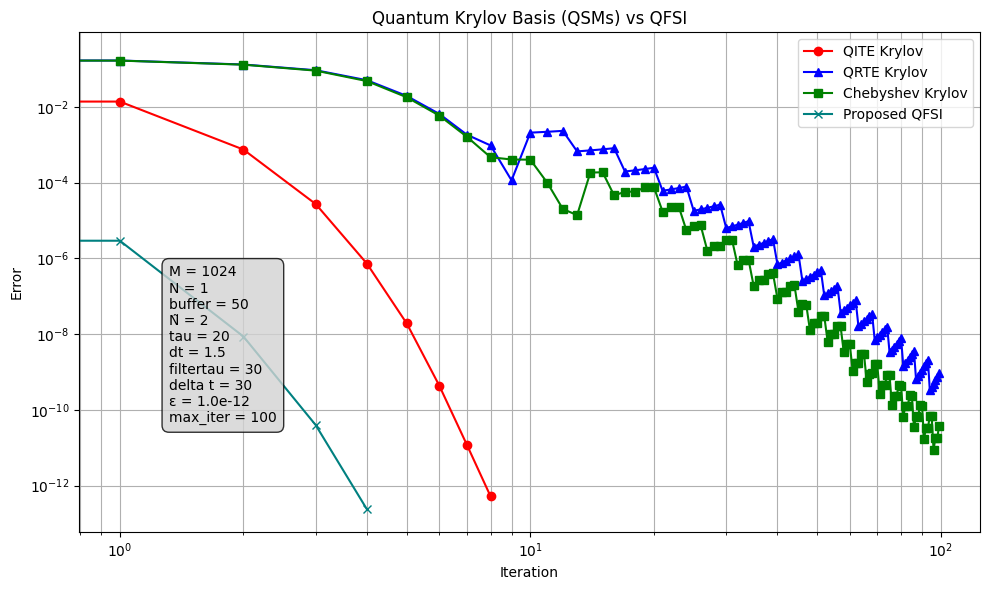

In [30]:
plt.figure(figsize=(10, 6))
plt.title('Quantum Krylov Basis (QSMs) vs QFSI')
plt.plot(np.arange(qite_itr), qite_abs_error[1:], marker='o', label='QITE Krylov', color='red')
plt.plot(np.arange(qrte_itr), qrte_abs_error[1:], marker='^', label='QRTE Krylov', color='blue')
plt.plot(np.arange(chebyshev_itr), chebyshev_abs_error[1:], marker='s', label='Chebyshev Krylov', color='green')
plt.plot(np.arange(method_itr), method_abs_error[1:], marker='x', label='Proposed QFSI', color='teal')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.grid(True, 'both', 'both')
plt.legend()
info_text = (
    f"M = {M}\n"
    f"N = {N}\n"
    f"buffer = {buffer}\n"
    f"Ñ = {Ntilde}\n"
    f"tau = {tau}\n"
    f"dt = {dt}\n"
    f"filtertau = {filtertau}\n"
    f"delta t = {deltat}\n"
    f"ε = {epsilon:.1e}\n"
    f"max_iter = {max_iter}"
)

# Adjust position (x=0.65, y=0.5) as needed
plt.text(0.1, 0.22, info_text, transform=plt.gca().transAxes,
         fontsize=10, bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgrey', alpha=0.8))
plt.legend()
plt.tight_layout()
plt.show()

In [31]:
print("Original:", np.sort(np.linalg.eigvalsh(H))[:N])
print("QITE Eigenvals: ", 2*qite_eigenvals[:N]-1)
print("QRTE Eigenvals: ", qrte_eigenvals[:N])
print("Chebyshev Eigenvals:", chebyshev_eigenvals[:N])
print("Our Method:", method_eigenvals[:N])

Original: [-0.33329481]
QITE Eigenvals:  [-0.33329481]
QRTE Eigenvals:  [-0.33329481]
Chebyshev Eigenvals: [-0.33329481]
Our Method: [-0.33329481]


## Excited States

In [34]:
# Parameters
# np.random.seed(15) # For reproducibility
M =  1024 # Dimension of the matrix
N = 10 # Number of eigenvalues
s = 3 # Sparsity of the matrix
realvals = True # Whether to generate real values or complex values
seed = 42 # Random seed for reproducibility

H = generate_s_sparse_hermitian(M=M, s=s, real_vals=realvals, seed=seed)
eigvals = np.linalg.eigvalsh(H)

buffer = 10  # Buffer for the number of eigenvalues
Ntilde = int(np.ceil((1+(buffer/100)) * N))  # Initial space size
tau = 0.2 # Time step for the QITE method
dt = 1.5 # Time step for the QRTE method
filtertau = 30 # Time step for our method
deltat = 30 # Time step for our method
epsilon = 1e-12  # Tolerance for convergence
max_iter = 100 # Maximum number of iterations

psi_0 = np.random.randn(M, 1) + 1j*np.random.randn(M, 1)
psi_0 /= np.linalg.norm(psi_0, axis=0, keepdims=True)

print("Maximum Albsolute Eigenvalue:", np.max(np.abs(np.linalg.eigvalsh(H))))
# print("Matrix:", H)
print("Matrix Size: ", M)
print("Number of Eigenvalues desired: ", N)
print("Sparsity of the Matrix: ", s)
print("Initial space size: ", Ntilde)
print("Real Values: ", realvals)
print("Random Seed: ", seed)
print("Buffer: ", buffer)
print("dt:", dt)
print("tau: ", tau)
print("deltat: ", deltat)
print("filtertau: ", filtertau)
print("Convergence Threshold: ", epsilon)
print("Max Iterations: ", max_iter)

Maximum Albsolute Eigenvalue: 0.33333333333333287
Matrix Size:  1024
Number of Eigenvalues desired:  10
Sparsity of the Matrix:  3
Initial space size:  11
Real Values:  True
Random Seed:  42
Buffer:  10
dt: 1.5
tau:  0.2
deltat:  30
filtertau:  30
Convergence Threshold:  1e-12
Max Iterations:  100


In [37]:
# qite_eigenvals, qite_abs_error, qite_itr = QITE(H, psi_0, N, tau, buffer, epsilon, max_iter)
# qrte_eigenvals, qrte_abs_error, qrte_itr = QRTE(H, psi_0, N, dt, buffer,  epsilon, max_iter)
chebyshev_eigenvals, chebyshev_abs_error, chebyshev_itr = chebyshev(H, psi_0, N, buffer, epsilon, max_iter)
method_eigenvals, method_eigenvecs, method_abs_error, method_itr = method(H, psi_0, N, deltat, filtertau, buffer, epsilon, max_iter)


Chebyshev Quantum Krylov basis Diagonalization Parameters
Dimension of H matrix: 1024
Number of desired Eigenvalues: 10
Initial Space Size: 11
Buffer: 10%
Convergence Threshold: 1e-12
Max Iterations: 100

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Matrix is not positive definite. Regularizing
Iteration 6
Matrix is not positive definite. Regularizing
Iteration 7
Matrix is not positive definite. Regularizing
Iteration 8
Matrix is not positive definite. Regularizing
Iteration 9
Matrix is not positive definite. Regularizing
Iteration 10
Matrix is not positive definite. Regularizing
Iteration 11
Matrix is not positive definite. Regularizing
Iteration 12
Matrix is not positive definite. Regularizing
Iteration 13
Matrix is not positive definite. Regularizing
Iteration 14
Matrix is not positive definite. Regularizing
Iteration 15
Matrix is not positive definite. Regularizing
Iteration 16
Matrix is not positive definite. Regularizing
Iteration 17
Matrix is not posi

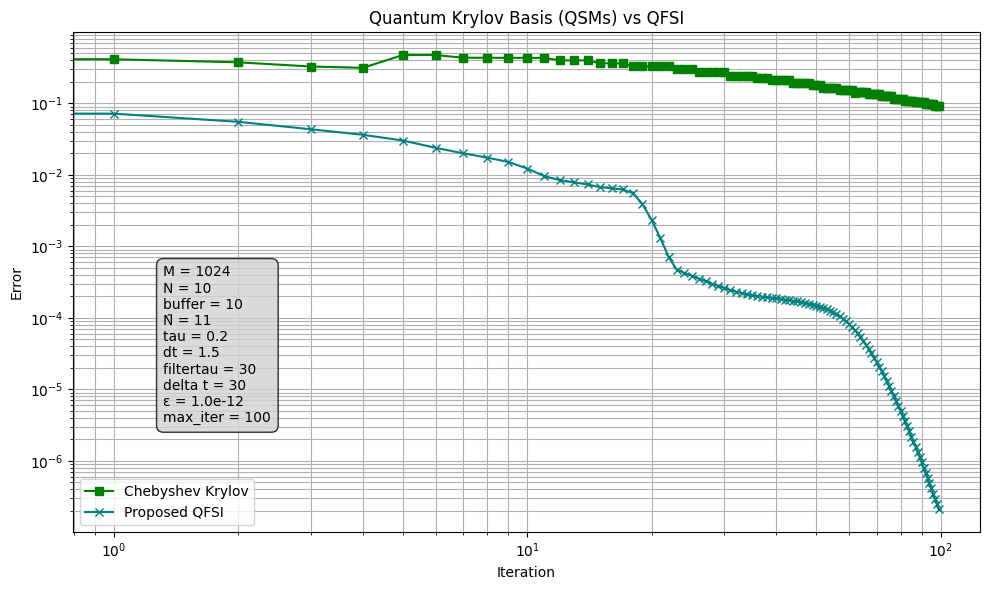

In [39]:
plt.figure(figsize=(10, 6))
plt.title('Quantum Krylov Basis (QSMs) vs QFSI')
# plt.plot(np.arange(qite_itr), qite_abs_error[1:], marker='o', label='QITE Krylov', color='red')
# plt.plot(np.arange(qrte_itr), qrte_abs_error[1:], marker='^', label='QRTE Krylov', color='blue')
plt.plot(np.arange(chebyshev_itr), chebyshev_abs_error[1:], marker='s', label='Chebyshev Krylov', color='green')
plt.plot(np.arange(method_itr), method_abs_error[1:], marker='x', label='Proposed QFSI', color='teal')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.grid(True, 'both', 'both')
plt.legend()
info_text = (
    f"M = {M}\n"
    f"N = {N}\n"
    f"buffer = {buffer}\n"
    f"Ñ = {Ntilde}\n"
    f"tau = {tau}\n"
    f"dt = {dt}\n"
    f"filtertau = {filtertau}\n"
    f"delta t = {deltat}\n"
    f"ε = {epsilon:.1e}\n"
    f"max_iter = {max_iter}"
)

# Adjust position (x=0.65, y=0.5) as needed
plt.text(0.1, 0.22, info_text, transform=plt.gca().transAxes,
         fontsize=10, bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgrey', alpha=0.8))
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
print("Original:", np.sort(np.linalg.eigvalsh(H))[:N])
print("QITE Eigenvals: ", 2*qite_eigenvals[:N]-1)
print("QRTE Eigenvals: ", qrte_eigenvals[:N])
print("Chebyshev Eigenvals:", chebyshev_eigenvals[:N])
print("Our Method:", method_eigenvals[:N])

Original: [-0.33329481 -0.26353675]
QITE Eigenvals:  [-0.33329481 -0.26346829]
QRTE Eigenvals:  [-0.33329481 -0.26348377]
Chebyshev Eigenvals: [-0.33329481 -0.26352709]
Our Method: [-0.33329481 -0.26353675]


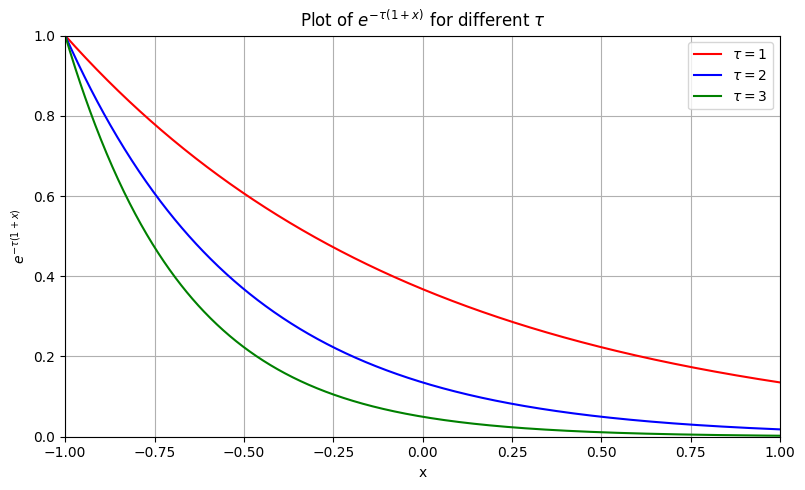

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
x = np.linspace(-1, 1, 1000)
y_1 = np.exp(-1 * (1 + x))
y_2 = np.exp(-2 * (1+x))
y_3 = np.exp(-3 * (1+x))

# Plot
plt.figure(figsize=(8, 5))
plt.plot(x, y_1, label=r'$\tau =1$', color='red')
plt.plot(x, y_2, label=r'$\tau =2$', color='blue')
plt.plot(x, y_3, label=r'$\tau =3$', color='green')

plt.title(r'Plot of $e^{{-\tau (1 + x)}}$ for different $\tau $')
plt.xlabel('x')
plt.ylabel(r'$e^{-\tau (1 + x)}$')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.xlim(-1, 1)
plt.ylim(0, 1)
plt.show()
